In [1]:
from unityagents import UnityEnvironment
import numpy as np
from agent import Agent
from collections import deque
import random
import torch
import matplotlib.pyplot as plt
from torchsummary import summary
%matplotlib inline

In [2]:
env = UnityEnvironment(file_name="../Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           4,864
            Linear-2                   [-1, 64]           8,256
            Linear-3                   [-1, 32]           2,080
            Linear-4                    [-1, 4]             132
Total params: 15,332
Trainable params: 15,332
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.06
----------------------------------------------------------------
Episode 100	Average Score: 0.25
Episode 200	Average Score: 2.15
Episode 300	Average Score: 5.67
Episode 400	Average Score: 7.29
Episode 500	Average Score: 8.95
Episode 600	Average Score: 10.59
Episode 700	Average Score: 11.71
Episode 800	Average Score: 11.57
Episode 900	Average Score: 10.98
Episode 

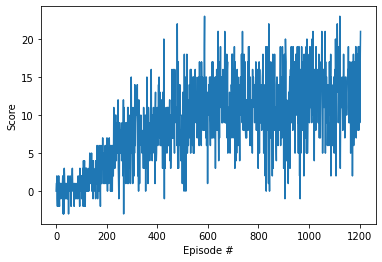

In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=False)[brain_name]
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

agent = Agent(state_size = state_size, action_size = action_size, seed = 0)
summary(agent.qnetwork_local,(state_size,))

n_episodes = 2000
max_steps_per_ep = 1000
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995

B_P = 0.4
B_step = 1/2000
B_max = 1.0

scores = []
scores_window = deque(maxlen=100)
eps = eps_start

for ep in range(1,1+n_episodes):
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0] 
    score = 0
    for step in range(max_steps_per_ep):
        action = agent.act(state, eps)
        env_info = env.step(action.astype(int))[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        priority = agent.priority(state,action,reward,next_state)
        agent.step(state,action,reward,next_state,done,priority,B_P)
        state = next_state
        score += reward
        if done:
            break
    eps = max(eps_end, eps_decay*eps)
    B_P = max(B_P+B_step,B_max)
    scores_window.append(score)
    scores.append(score)
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(ep, np.mean(scores_window)), end="")
    if ep % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(ep, np.mean(scores_window)))
    if np.mean(scores_window)>=13.0:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(ep-100, np.mean(scores_window)))
        torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
        break

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
env.close()